<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [50]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

%matplotlib inline

import pylab as plt

# Estadística frecuentista

#### Formulando una hipótesis

Realizada la observación de la necesidad de un test, es necesario plantear una hipótesis. Dado que no sabemos si el cambio funciona mejor o peor, usaremos el [test de dos colas]:

$$H_0: p = p_0$$
$$H_1: p \ne p_0$$

donde $p$ y $p_0$ son las tasas de retención del cambio en la puerta 30  y el viejo diseño respectivamente. Además, establecemos un **intervalo de confianza del 95%**:

$$\alpha = 0.05$$

El valor de $\alpha$ es el umbral para ese intervalo de confianza, que lo que quiere decir es que "si la probabilidad de observar un resultado, el $p$-valor, es menor que $\alpha$, entonces podemos rechazar la hipótesis nula". Nuestro $\alpha=0.05$ indica un 5% de probabilidad, dando un intervalo de confianza, 1 - $\alpha$, del 95%.

In [6]:
# datos
datos = pd.read_csv("data/cookie_cats.csv")
datos.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 7.1 MB


In [71]:
gate_30.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False


In [69]:
#separamos en dos grupos
gate_30 = datos[datos["version"]=="gate_30"]
gate_40 = datos[datos["version"]=="gate_40"]

In [74]:
#comprobamos independencia de los datos
pd.crosstab(datos.version, datos.version)

version,gate_30,gate_40
version,,
gate_30,44700,0
gate_40,0,45489


In [76]:
gate_30.shape

(44700, 5)

In [77]:
gate_40.shape

(45489, 5)

In [78]:
#tenemos dos experimentos independientes (r1, r7), dos muestras:
# muestreo de R1

control = gate_30.sample(n=44700, random_state=22)

tratamiento = gate_40.sample(n=45489, random_state=22)

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True


In [79]:
ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,5069865,gate_40,4,False,False
90185,5493639,gate_40,10,False,False
90186,6977127,gate_40,11,False,False
90187,6482593,gate_40,2,False,False
90188,9641592,gate_40,3,False,False


In [80]:
ab_test.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [81]:
tasas_conversion = ab_test.groupby('version')['retention_1']    # agrupacion por grupo


std = lambda x: np.std(x, ddof=0)              # std
error_std= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,sem
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


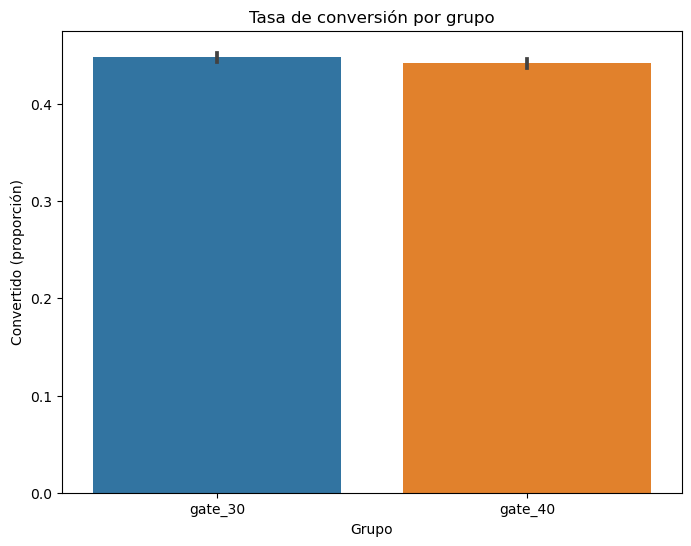

In [82]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])


plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [83]:
# seleccionar grupos

control_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_res=ab_test[ab_test.version=='gate_40']['retention_1']

# testeo para retention_1

In [65]:
impresiones=[20034, 20119]  # count  , impresiones
    
conversiones=[control_res.sum(), trat_res.sum()]    # conversiones


z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [66]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para gate_30 retention_1: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para gate_40 retention_1: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 2.15
p-valor: 0.032
intervalo conf 95% para gate_30 retention_1: [0.441, 0.455]
intervalo conf 95% para gate_40 retention_1: [0.431, 0.444]


**Conclusiones**
El p-valor: 0.032 por lo que es menor a nuestro intervalo de confianza por lo que podemos rechazar h0


# testeo para retention_7

In [88]:
tasas_conversion = ab_test.groupby('version')['retention_7']    # agrupacion por grupo


std = lambda x: np.std(x, ddof=0)              # std
error_std= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,sem
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


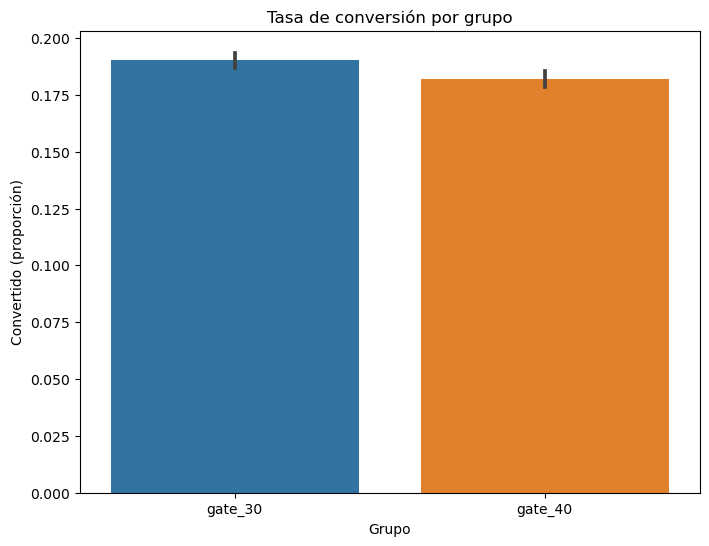

In [89]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'])


plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [87]:
# testeo para retention_7
# seleccionar grupos

control_res=ab_test[ab_test.version=='gate_30']['retention_7']

trat_res=ab_test[ab_test.version=='gate_40']['retention_7']



In [95]:
impresiones=[20034, 20119]  # count  , impresiones
    
conversiones=[control_res.sum(), trat_res.sum()]    # conversiones


z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [96]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para gate_30 retention_1: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para gate_40 retention_1: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 2.62
p-valor: 0.009
intervalo conf 95% para gate_30 retention_1: [0.418, 0.431]
intervalo conf 95% para gate_40 retention_1: [0.405, 0.418]


**Conclusiones**
El p-valor: 0.009 por lo que es menor a nuestro intervalo de confianza por lo que podemos rechazar h0

# conclusiones

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

Podemos observar que algo varía, para arriba o para bajo, los gráficos muestran una diferencia, así que podemos afirmar que algo cambia.

# Estadística bayesiana

In [97]:

from scipy.stats import beta
import numpy as np
from math import lgamma
import matplotlib.pyplot as plt

In [98]:
gate_30.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False


In [104]:
sum(gate_30["retention_7"] == True)

8502

In [99]:
gate_40.head()

,userid,version,sum_gamerounds,retention_1,retention_7
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
7,1444,gate_40,2,False,False


In [102]:
sum(gate_40["retention_7"] == True)

8279

Experimento 1: **retention_1**

In [130]:
datos.shape

(90189, 5)

In [127]:
datos.value_counts("retention_1")

retention_1
False    50036
True     40153
dtype: int64

In [136]:
gate_30.value_counts("retention_1")[1]

20034

In [140]:
control = sum(gate_30.value_counts("retention_1"))

In [137]:
convs_control = gate_30.value_counts("retention_1")[1]

In [139]:
test = sum(gate_40.value_counts("retention_1"))

In [138]:
convs_test = gate_40.value_counts("retention_1")[1]

In [141]:
# los datos son conocidos : personas que siguen jugando depués de la puerta para test y control
CR_ctrl = convs_control/control
CR_test = convs_test/test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [143]:
# a prioris

a_C, b_C = 1+convs_control, 1+control-convs_control

a_T, b_T = 1+convs_test, 1+test-convs_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [144]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [308]:
x=np.linspace(0, 1, 10)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

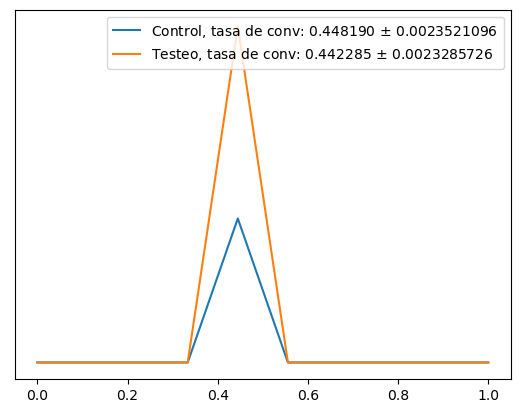

In [309]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [206]:
salto = (beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.013175098158249857

In [213]:
prob = 1 - beta_test.cdf(0.0024)

prob

1.0

In [276]:
'''El test disminuye la tasa de retención en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test disminuye la tasa de retención en un -1.32%, con una probabilidad del 100.00%'

In [311]:
def plot(betas, names, linf=0, lsup=0.006):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

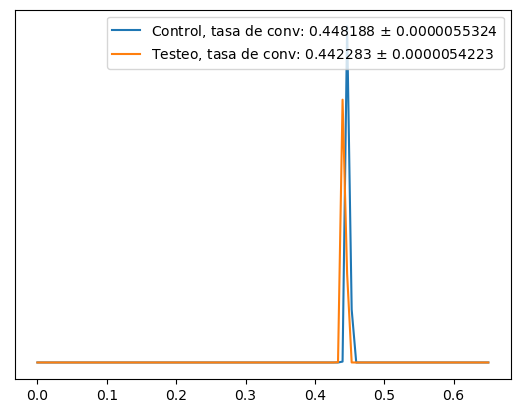

In [333]:
plot([beta_control, beta_test], ['Control', 'Testeo'], linf=0.000001, lsup=0.65)